In [49]:
import re
import pandas as pd
from pathlib import Path


class MergeData:

    def __init__(self, raw_data_path: Path, output_data_path: Path):
        self.raw_data_path = raw_data_path
        self.output_data_path = output_data_path
        self.html_regexp = re.compile(r'<.*?>')
        self.df_train = pd.read_csv(raw_data_path+'train.csv')
        self.df_json = pd.read_json(raw_data_path + 'vacancy_descriptions/1_parsed.json')
        self.json_paths = [raw_data_path + 'vacancy_descriptions/' + str(i) + '_parsed.json' for i in range(2, 6)]
        self.df_okz = pd.read_csv(raw_data_path+'okz_3_4_professions.csv', sep='\t')

    def merge(self):

        df_json = self.df_json.copy(deep=True)
        df_okz = self.df_okz.copy(deep=True)
        df_train = self.df_train.copy(deep=True)

        for path in self.json_paths:
            df_json_temp = pd.read_json(path)
            df_json = pd.concat([df_json, df_json_temp], axis=0)

        df_json['content'] = df_json['Content'].apply(lambda x: list(x.values()))
        df_json['index'] = df_json['ID']
        df_json = df_json.drop(['Content', 'ID'],axis=1)

        df_okz['profession_desc'] = df_okz['description']
        df_okz['target'] = df_okz['code']
        df_okz = df_okz.drop(['control_number', 'description', 'code'], axis=1)

        df = df_json.merge(df_train, how='left', on='index')
        df = df.merge(df_okz, on='target', how='left')

        df = df.drop('name', axis=1)
        df['target'] = df['target'].fillna(-1.0)
        df['target'] = df['target'].astype(int)
        df['description'] = df['description'].astype(str)
        df['description'] = df['description'].apply(lambda x:  self.html_regexp.sub(r'', x))

        df_labeled = df[df['target'] != -1].to_csv(self.output_data_path+'labeled.csv', index=False)
        df_unlabeled = df[df['target'] == -1].to_csv(self.output_data_path+'unlabeled.csv', index=False)

In [50]:

raw_data_path = str('../../data/raw/')
output_data_path = str('../../data/processed/')
merge_data = MergeData(raw_data_path, output_data_path)
merge_data.merge()

In [51]:
# open ../../data/processed/labeled.csv
# open ../../data/processed/unlabeled.csv
labeled = pd.read_csv('../../data/processed/labeled.csv')
unlabeled = pd.read_csv('../../data/processed/unlabeled.csv')

In [60]:
unlabeled.head()

,Position,content,index,description,target,profession,profession_desc
0,Секретарь,"[['Срочно требуется:Секретарь', 'Выплаты ежедн...",363107946,Срочно требуется: Секретарь. Выплаты ежедневно...,-1,NaN,NaN
1,Персональный менеджер,"[['окончили вуз', 'разбираетесь в законах о ба...",363144355,NaN,-1,NaN,NaN
2,Продавец-консультант ECCO (ТЦ Сити Молл),[['Обладаешь хорошими коммуникативными навыкам...,363340232,Датская компания ECCO более 50 лет входит в тр...,-1,NaN,NaN
3,Агент/Риэлтор (Помощник Риэлтора),[['Организовывать и проводить просмотры/показы...,363383054,NaN,-1,NaN,NaN
4,Специалист по поддержке клиентов,[['Легко ориентируешься в огромном потоке ново...,363982236,NaN,-1,NaN,NaN


In [61]:
unlabeled.iloc[0]['content']

"[['Срочно требуется:Секретарь', 'Выплаты ежедневно', 'Мы работаем с лучшими залами  Государственный Кремлевский Дворец, Крокус Сити Холл, Международный Дом Музыки и другие', 'Мы работаем с лучшими артистами']]"

In [62]:
unlabeled.iloc[0]['description']

'Срочно требуется: Секретарь. Выплаты ежедневно. Мы работаем с лучшими залами - Государственный Кремлевский Дворец, Крокус Сити Холл, Международный Дом Музыки и другие! Мы работаем с лучшими артистами!   Нам нужно от Вас:  грамотная русская речь позитивный подход к клиентам желание работать и развиваться интенсивно работать с клиентами полный рабочий день готовность приступить прямо сейчас    Что нужно делать:  работать с существующей базой клиентов Компании продавать билеты по телефону развивать свою команду для открытия собственного офиса Компании    Что Мы предлагаем:  пятидневная бизнес неделя (пн-пт, 09:30 - 18:30) ежедневный зароботок в зависимости от личных результатов (от 5 000 до 20 000 рублей в день) карьерный рост в течение первых нескольких месяцев в бизнесе до управляющего офисом Компании неограниченные заработки для управляющих офисами Компании семинары с лучшим бизнес-тренером в России бесплатное посещение мероприятий Компании \nГрамотная русская речь. Позитивный подход 

In [63]:
okz = pd.read_csv('../../data/raw/okz_3_4_professions.csv', sep='\t')

In [75]:
# find in profession "секретарь"
okz[okz['description'].str.contains('Продавец-консультант')]['profession'].iloc[3]

'Демонстраторы товаров '

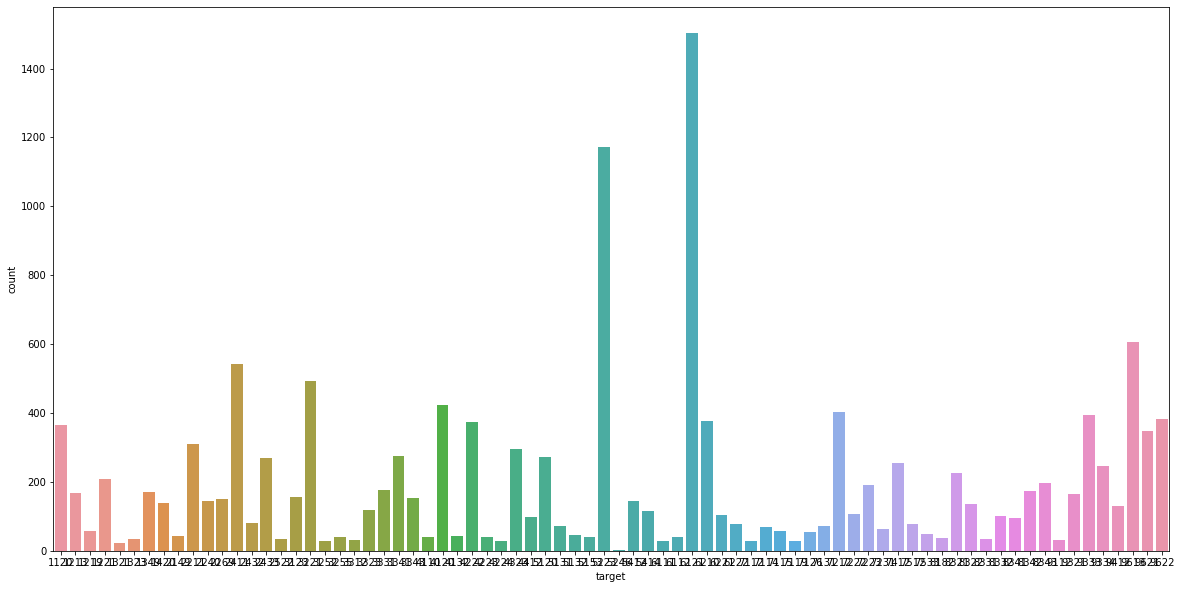

In [80]:
import matplotlib.pyplot as plt
import seaborn as sns

# plot distribution of target
plt.figure(figsize=(20, 10))
sns.countplot(x='target', data=labeled)
plt.show()

In [82]:
labeled.groupby('target').count()['index'].sort_values(ascending=False)

target
6121    1503
5223    1173
9613     606
2411     543
3221     492
        ... 
7119      28
7112      28
6111      28
1321      23
5246       1
Name: index, Length: 76, dtype: int64

In [87]:
unlabeled.head()

,Position,content,index,description,target,profession,profession_desc
0,Секретарь,"[['Срочно требуется:Секретарь', 'Выплаты ежедн...",363107946,Срочно требуется: Секретарь. Выплаты ежедневно...,-1,NaN,NaN
1,Персональный менеджер,"[['окончили вуз', 'разбираетесь в законах о ба...",363144355,NaN,-1,NaN,NaN
2,Продавец-консультант ECCO (ТЦ Сити Молл),[['Обладаешь хорошими коммуникативными навыкам...,363340232,Датская компания ECCO более 50 лет входит в тр...,-1,NaN,NaN
3,Агент/Риэлтор (Помощник Риэлтора),[['Организовывать и проводить просмотры/показы...,363383054,NaN,-1,NaN,NaN
4,Специалист по поддержке клиентов,[['Легко ориентируешься в огромном потоке ново...,363982236,NaN,-1,NaN,NaN


In [98]:
# open ../data/raw/okz_3_4_professions.csv
okz = pd.read_csv('../../data/raw/okz_3_4_professions.csv', sep='\t')
okz.head()

,code,control_number,profession,description
0,111,6.0,Руководители (представители) федеральных и рег...,Руководители\n(представители) федеральных и р...
1,1111,7.0,Руководители федеральных и региональных органо...,Руководители (представители) федеральных и ре...
2,1112,3.0,Руководители (представители) федеральных и рег...,\nРуководители (представители) федеральных и ...
3,1113,7.0,Руководители органов местного самоуправления,Руководители органов местного самоуправления ...
4,1114,0.0,Высшие должностные лица политических и обществ...,Высшие должностные лица политических\nи общес...


In [94]:
# function for cleaning position name
def clean_position_name(position_name) -> list:
    # delete after (
    position_name = re.sub(r'\(.*?\)', '', position_name)
    # parse position name by space / - ,
    position_name = re.sub(r'[\s/-]', ' ', position_name)
    # delete all symbols except letters
    position_name = re.sub(r'[^а-яА-Я]', ' ', position_name)
    # split by space
    position_name = position_name.split()
    # delete empty strings
    position_name = list(filter(None, position_name))
    return position_name

clean_position_name('Агент/Риэлтор (Помощник Риэлтора)')

['Агент', 'Риэлтор']

In [103]:
# df of cleaned position names, index and target
df_position_name = pd.DataFrame(columns=['Position', 'index', 'target'])
df_position_name['Position'] = unlabeled['Position'].apply(clean_position_name)
df_position_name['index'] = unlabeled['index']
df_position_name['target'] = unlabeled['target']
df_position_name.head()

,Position,index,target
0,[Секретарь],363107946,-1
1,"[Персональный, менеджер]",363144355,-1
2,"[Продавец, консультант]",363340232,-1
3,"[Агент, Риэлтор]",363383054,-1
4,"[Специалист, по, поддержке, клиентов]",363982236,-1


In [117]:
# find best match okz description for position name
def find_best_match(df_position_name) -> dict:
    # {position_name: {okz_code: count of matches}}
    position_name_okz = {}
    for index, row in df_position_name.iterrows():
        position_name = row['Position']
        okz_code = row['target']
        position_name_okz[index] = {}
        for i in range(len(position_name)):
            for j in range(i+1, len(position_name)):
                word = ' '.join(position_name[i:j])
                okz_desc = okz[okz['description'].str.contains(word)]['code'].values
                for code in okz_desc:
                    if code in position_name_okz[index]:
                        position_name_okz[index][code] += 3
                    else:
                        position_name_okz[index][code] = 2
        for word in position_name:
            okz_desc = okz[okz['description'].str.contains(word)]['code'].values
            for code in okz_desc:
                if code in position_name_okz[index]:
                    position_name_okz[index][code] += 1.5
                else:
                    position_name_okz[index][code] = 1
            
    return position_name_okz

In [133]:
position_name_okz = find_best_match(df_position_name)

In [125]:
position_name_okz_best = [max(position_name_okz[ind], key=position_name_okz[ind].get, default=-1) for ind in position_name_okz]

In [130]:
unlabeled['target'] = position_name_okz_best

In [131]:
unlabeled.head()

,Position,content,index,description,target,profession,profession_desc
0,Секретарь,"[['Срочно требуется:Секретарь', 'Выплаты ежедн...",363107946,Срочно требуется: Секретарь. Выплаты ежедневно...,2612,NaN,NaN
1,Персональный менеджер,"[['окончили вуз', 'разбираетесь в законах о ба...",363144355,NaN,3423,NaN,NaN
2,Продавец-консультант ECCO (ТЦ Сити Молл),[['Обладаешь хорошими коммуникативными навыкам...,363340232,Датская компания ECCO более 50 лет входит в тр...,1420,NaN,NaN
3,Агент/Риэлтор (Помощник Риэлтора),[['Организовывать и проводить просмотры/показы...,363383054,NaN,3334,NaN,NaN
4,Специалист по поддержке клиентов,[['Легко ориентируешься в огромном потоке ново...,363982236,NaN,351,NaN,NaN


In [132]:
unlabeled.to_csv('../../data/processed/unlabeled_with_labels.csv', index=False)